# Project Description and Goals

Zillow is one of the most popular real estate databases online. One of Zillow’s key features is its Zestimates, a popular consumer tool for seeing how much homes are worth.




Zestimates offer users a starting point in home valuation, but these numbers may not be as accurate as one might think for a variety of reasons and there may still be some error.




That is why Zillow's dataset includes the log error information, which is the difference between sales price and estimated price.



### What is driving the errors in Zestimates?

For this project we are working with the Zillow dataset using the 2017 properties and predictions data for single unit / single family homes.

This notebook consists of discoveries made and work that was done related to uncovering what the drivers of the error in the zestimate is.

### Objectives for this project include:
- Identifying the drivers for errors in Zestimates by incorporating clustering methodologies.
- Documenting process and analysis throughout the data science pipeline.
- Demonstrating the information that was discovered.
- Deliverables:
    - README.md file containing overall project information, how to reproduce work, and notes from project planning.
    - Jupyter Notebook Report detailing the pipeline process.
    - Python modules that automate the data acquistion, preparation, and exploration process. 

### Pipeline Process:
1. Acquire
2. Prepare
3. Explore
4. Model/Evaluate
5. Deliver

### Initial hypotheses
- Is log error  significantly different for properties in LA County vs Orange County vs Ventura County?
- Is there a correlation between square footage of a home and log error?
- Is there a relationship between tax value and log error?
- Could there be clusters in square footage and county location that can help predict log error? 

### Project Imports

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# acquire, prepare, and explore
import wrangle as w
import explore as ex

# statistical testing
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Regression Modeling
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Data Acquisition

In [2]:
df = w.get_zillow_data(cached=True)
df.head()

,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,bathroomcnt,...,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
0,NaN,NaN,2.0,NaN,NaN,NaN,10711855,1087254,NaN,2.0,...,NaN,6.037113e+13,-0.007357,2017-07-07,NaN,NaN,NaN,Central,NaN,NaN
1,NaN,NaN,2.0,NaN,NaN,1.0,10711877,1072280,NaN,2.0,...,NaN,6.037113e+13,0.021066,2017-08-29,Central,NaN,NaN,Central,NaN,NaN
2,NaN,NaN,2.0,NaN,NaN,1.0,10711888,1340933,NaN,2.0,...,NaN,6.037113e+13,0.077174,2017-04-04,Central,NaN,NaN,Central,NaN,NaN
3,NaN,NaN,2.0,NaN,NaN,NaN,10711910,1878109,NaN,2.0,...,NaN,6.037113e+13,-0.041238,2017-03-17,NaN,NaN,NaN,Central,NaN,NaN
4,NaN,NaN,2.0,NaN,NaN,NaN,10711923,2190858,NaN,2.0,...,NaN,6.037113e+13,-0.009496,2017-03-24,NaN,NaN,NaN,Central,NaN,NaN


In [3]:
#rows and columns
df.shape

(77413, 67)

In [4]:
#list of column names and data types with more information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77413 entries, 0 to 77412
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        222 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   heatingorsystemtypeid         49439 non-null  float64
 3   buildingclasstypeid           15 non-null     float64
 4   architecturalstyletypeid      206 non-null    float64
 5   airconditioningtypeid         24953 non-null  float64
 6   parcelid                      77413 non-null  int64  
 7   id                            77413 non-null  int64  
 8   basementsqft                  50 non-null     float64
 9   bathroomcnt                   77380 non-null  float64
 10  bedroomcnt                    77380 non-null  float64
 11  buildingqualitytypeid         49671 non-null  float64
 12  calculatedbathnbr             76771 non-null  float64
 13  d

In [5]:
#check nulls
df.isnull().sum()

typeconstructiontypeid          77191
storytypeid                     77363
heatingorsystemtypeid           27974
buildingclasstypeid             77398
architecturalstyletypeid        77207
airconditioningtypeid           52460
parcelid                            0
id                                  0
basementsqft                    77363
bathroomcnt                        33
bedroomcnt                         33
buildingqualitytypeid           27742
calculatedbathnbr                 642
decktypeid                      76799
finishedfloor1squarefeet        71390
calculatedfinishedsquarefeet      229
finishedsquarefeet12             3665
finishedsquarefeet13            77372
finishedsquarefeet15            74404
finishedsquarefeet50            71390
finishedsquarefeet6             77027
fips                               33
fireplacecnt                    69137
fullbathcnt                       642
garagecarcnt                    51939
garagetotalsqft                 51939
hashottubors

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
typeconstructiontypeid,222.0,6.040541e+00,5.572847e-01,4.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,1.300000e+01
storytypeid,50.0,7.000000e+00,0.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00
heatingorsystemtypeid,49439.0,3.920447e+00,3.592789e+00,1.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,2.400000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
airconditioningtypeid,24953.0,1.813289e+00,2.967894e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
parcelid,77413.0,1.300670e+07,3.480712e+06,1.071186e+07,1.153834e+07,1.253067e+07,1.421149e+07,1.676893e+08
id,77413.0,1.495761e+06,8.612707e+05,3.490000e+02,7.524130e+05,1.498471e+06,2.241718e+06,2.985182e+06
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77380.0,2.299134e+00,9.966566e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01


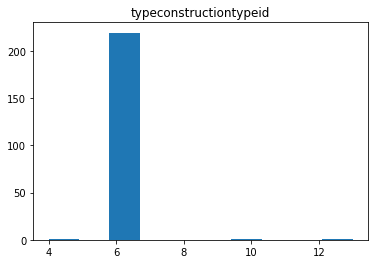

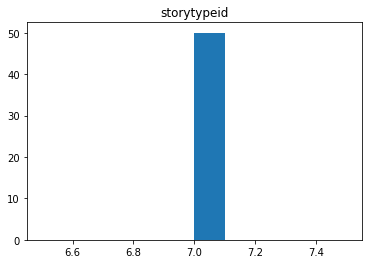

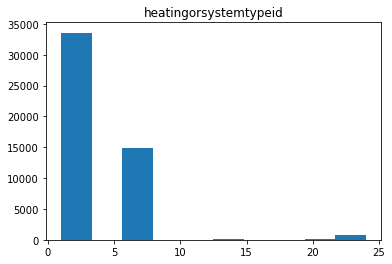

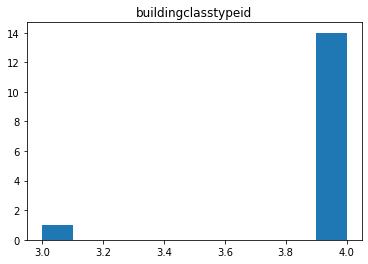

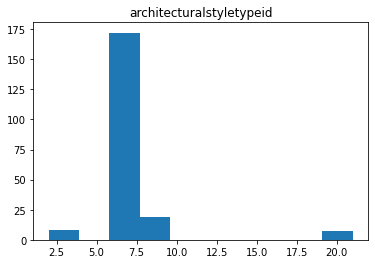

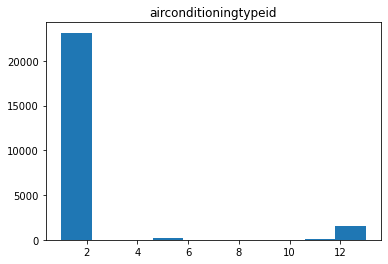

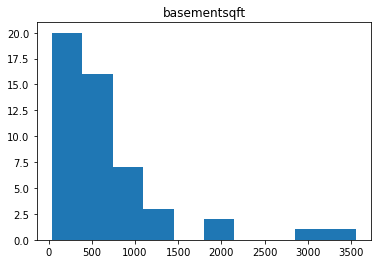

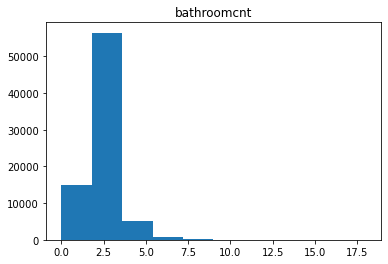

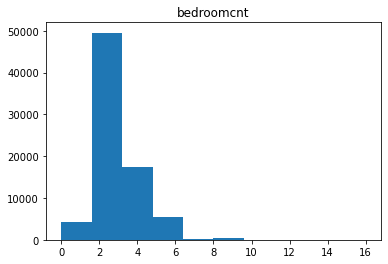

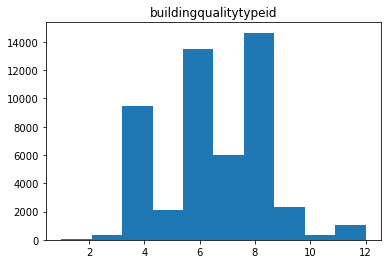

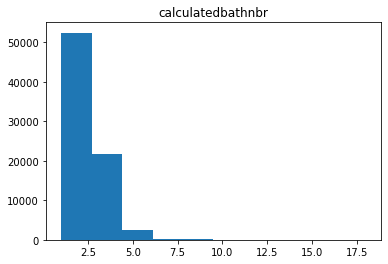

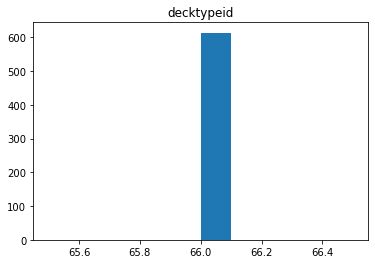

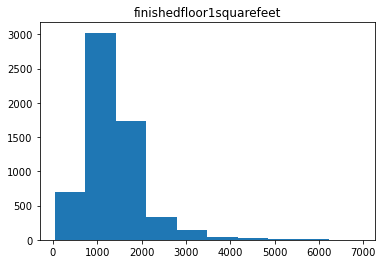

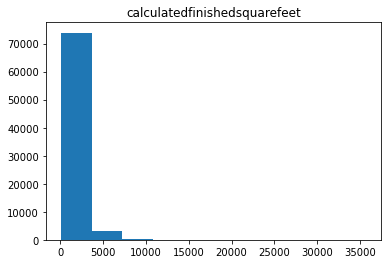

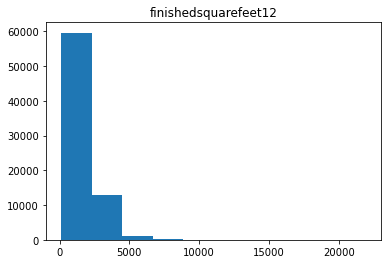

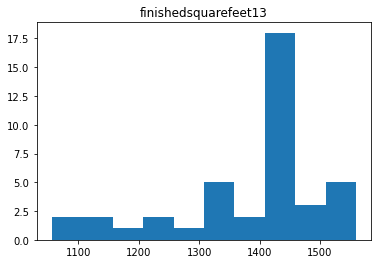

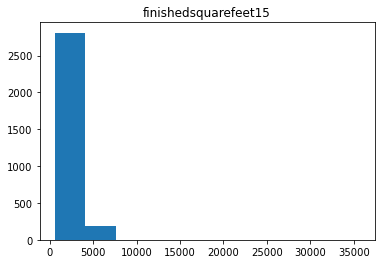

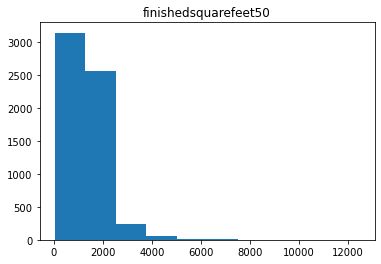

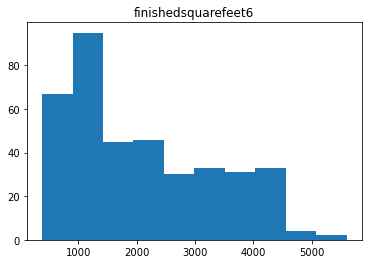

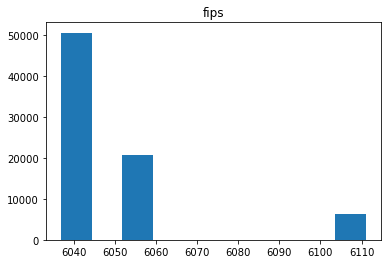

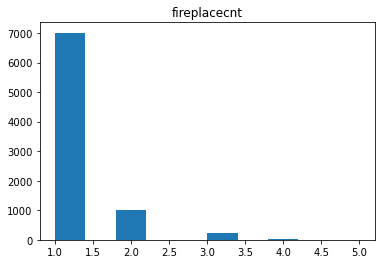

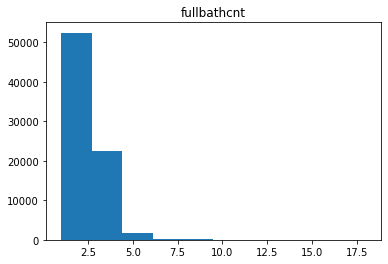

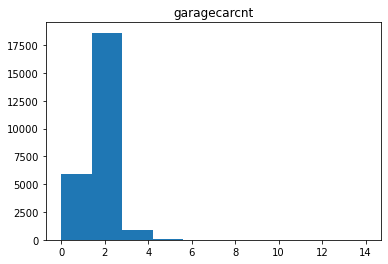

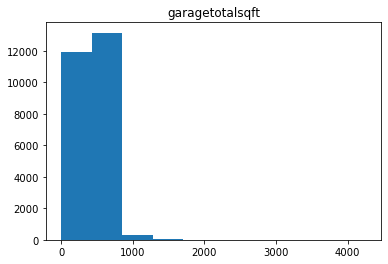

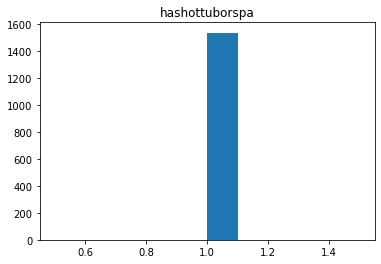

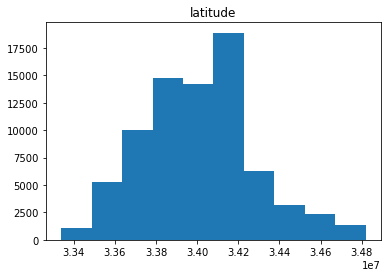

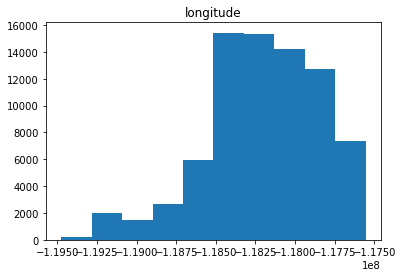

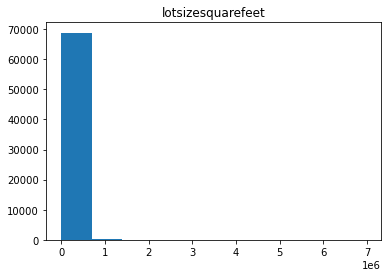

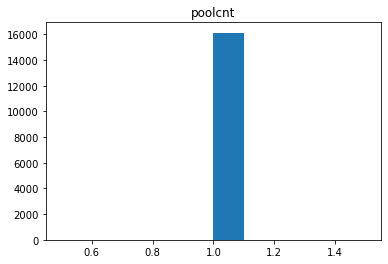

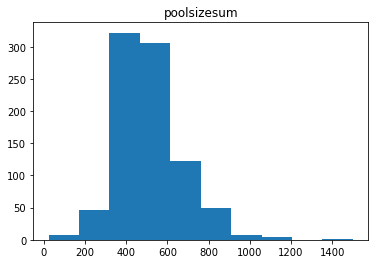

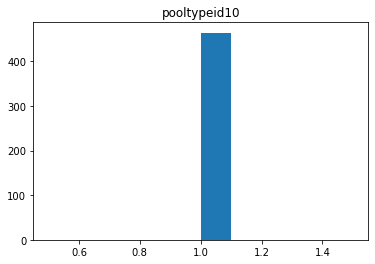

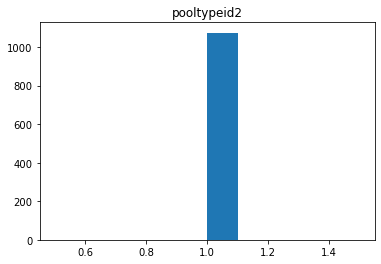

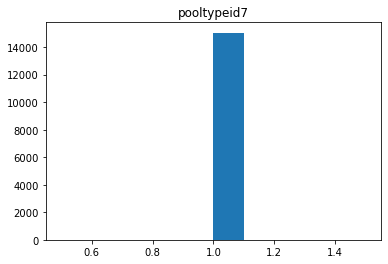

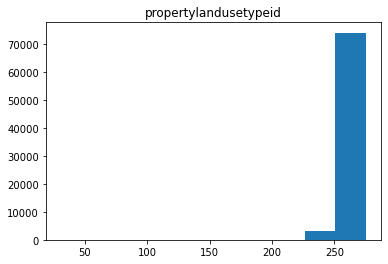

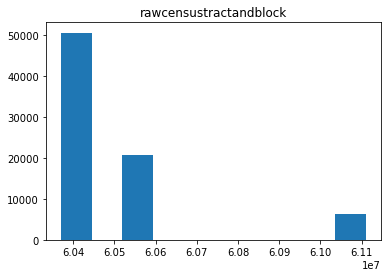

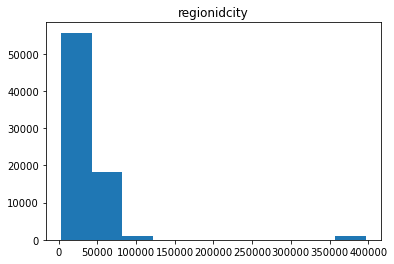

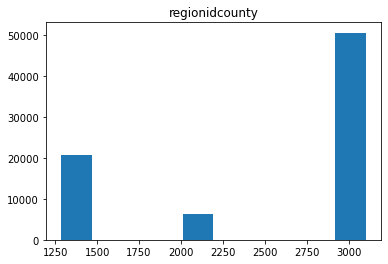

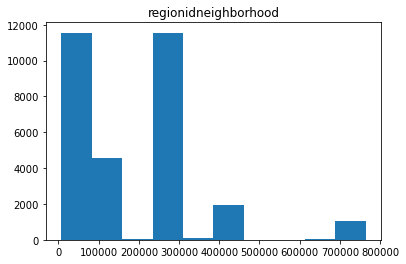

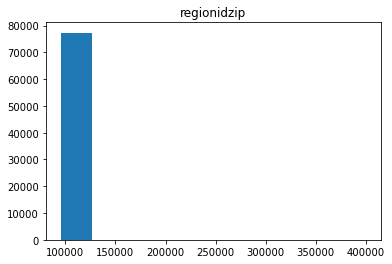

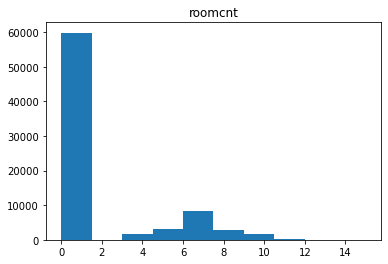

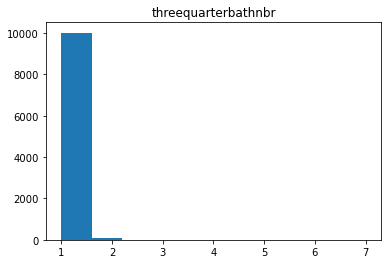

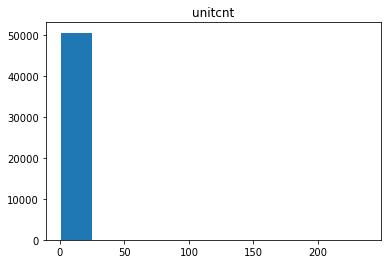

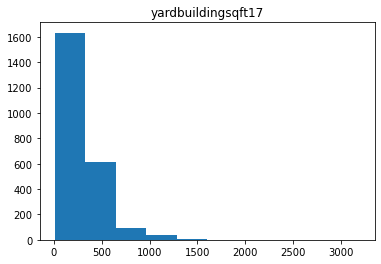

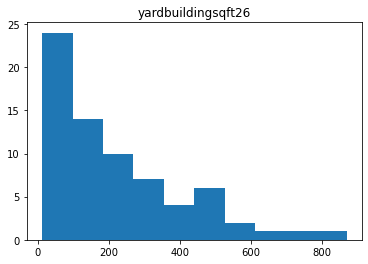

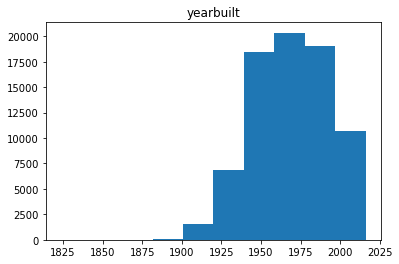

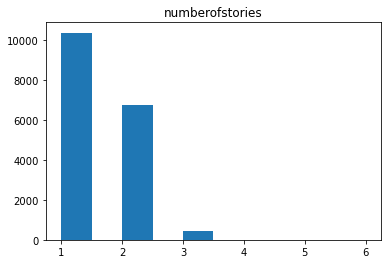

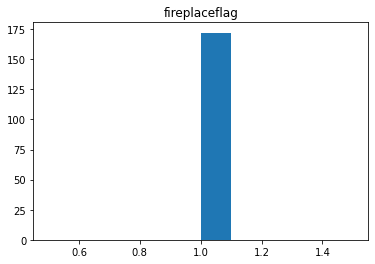

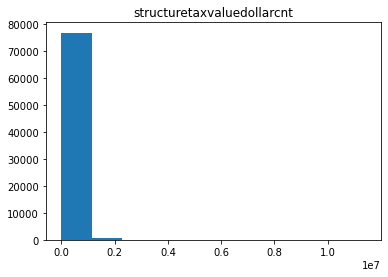

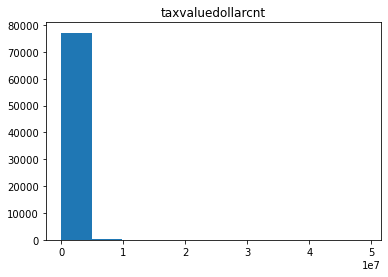

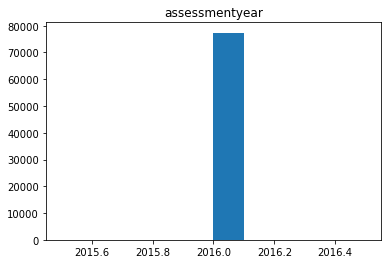

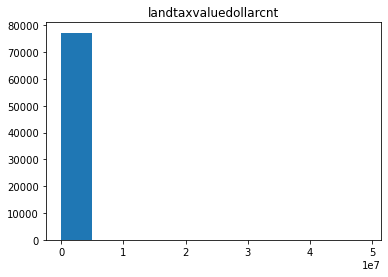

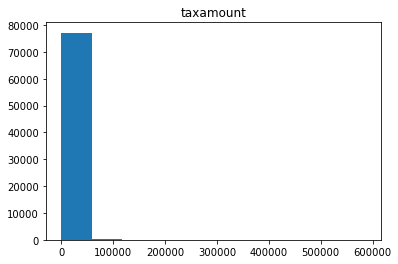

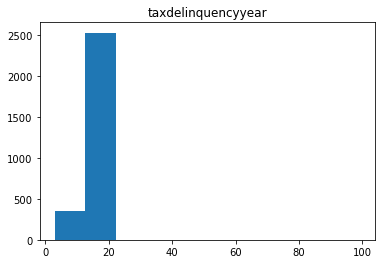

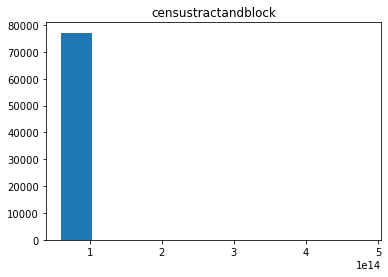

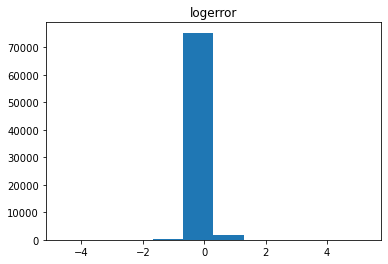

In [7]:
#distributions
for col in df.columns:
    if df[col].dtype != object and col != 'parcelid' and col != 'id':
        plt.hist(df[col])
        plt.title(col)
        plt.show()

### Findings
- many nulls in columns and rows that need to be removed and/or filled in 
- outliers are present and need to be removed
- redundant/unnecessary columns can be dropped
- columns can be renamed for better readability
- change datatypes to integers
- create dummy vars for fips
- index can be set to parcelid
- new features can be created for age, tax rate, acres, etc.

# Data Preparation

In [8]:
df = w.wrangle_zillow(cached=True)
df.head()

,heating_system_type_id,bathrooms,bedrooms,prop_sqft,fips,fireplace_cnt,latitude,longitude,lot_sqft,pool_cnt,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,2,2.0,3.0,2107.0,6037,0.0,0.342226,-1.186174,9158,1.0,...,1.227188,0.210239,0.2,0.5,118.488372,0.4,40.891461,0.3,0.666667,1
10711877,2,2.0,4.0,1882.0,6037,0.0,0.342203,-1.186164,9035,1.0,...,1.230895,0.207415,0.2,0.4,134.431456,0.4,45.047039,0.3,0.500000,1
10711888,2,2.0,4.0,1882.0,6037,0.0,0.342225,-1.186169,9800,0.0,...,1.229132,0.224977,0.2,0.4,136.870882,0.4,29.115510,0.3,0.500000,1
10711910,2,2.0,3.0,1477.0,6037,0.0,0.342219,-1.186157,11285,1.0,...,1.430790,0.259068,0.3,0.3,39.247123,0.1,1.777847,0.1,0.666667,1
10711923,2,2.0,4.0,1918.0,6037,0.0,0.342206,-1.186153,11239,1.0,...,1.261220,0.258012,0.3,0.4,87.522941,0.3,22.029540,0.3,0.500000,1


In [9]:
df.dtypes

heating_system_type_id          int64
bathrooms                     float64
bedrooms                      float64
prop_sqft                     float64
fips                            int64
fireplace_cnt                 float64
latitude                      float64
longitude                     float64
lot_sqft                        int64
pool_cnt                      float64
region_id_city                  int64
year_built                    float64
fireplace_flag                  int64
struct_tax_value              float64
tax_value                     float64
land_tax_value                float64
tax_amount                    float64
log_error                     float64
heating_system_desc            object
la_cnty                         uint8
orange_cnty                     uint8
ventura_cnty                    uint8
log_error_class              category
age                           float64
age_bin                       float64
taxrate                       float64
acres       

In [10]:
df.isnull().sum()

heating_system_type_id       0
bathrooms                    0
bedrooms                     0
prop_sqft                    0
fips                         0
fireplace_cnt                0
latitude                     0
longitude                    0
lot_sqft                     0
pool_cnt                     0
region_id_city               0
year_built                   0
fireplace_flag               0
struct_tax_value             0
tax_value                    0
land_tax_value               0
tax_amount                   0
log_error                    0
heating_system_desc          0
la_cnty                      0
orange_cnty                  0
ventura_cnty                 0
log_error_class              0
age                          0
age_bin                      0
taxrate                      0
acres                        0
acres_bin                    0
sqft_bin                     0
structure_dollar_per_sqft    0
structure_dollar_sqft_bin    0
land_dollar_per_sqft         0
lot_doll

In [11]:
#split
train_validate, test = train_test_split(df, train_size=.80, random_state=123)
train, validate = train_test_split(train_validate, random_state=123)

train.shape, validate.shape, test.shape

((36144, 35), (12048, 35), (12048, 35))

In [12]:
train.head()

,heating_system_type_id,bathrooms,bedrooms,prop_sqft,fips,fireplace_cnt,latitude,longitude,lot_sqft,pool_cnt,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
parcelid,,,,,,,,,,,,,,,,,,,,,
11053337,2,2.0,3.0,1641.0,6037,0.0,0.342330,-1.184758,8619,0.0,...,1.241154,0.197865,0.2,0.4,111.361974,0.4,35.337626,0.3,0.666667,1
11184707,2,2.0,3.0,1854.0,6037,0.0,0.346181,-1.181858,7212,0.0,...,2.338565,0.165565,0.2,0.4,21.457389,0.0,6.428730,0.2,0.666667,0
12111920,2,1.0,1.0,807.0,6037,0.0,0.341421,-1.181280,21646,1.0,...,1.221949,0.496924,0.3,0.1,103.100372,0.4,2.060103,0.1,1.000000,0
12730510,7,1.0,3.0,1045.0,6037,0.0,0.339189,-1.180198,6095,1.0,...,1.305227,0.139922,0.1,0.2,123.977990,0.4,36.748154,0.3,0.333333,0
11123078,2,3.0,4.0,2040.0,6037,0.0,0.344540,-1.184890,10419,1.0,...,1.406188,0.239187,0.2,0.5,149.644608,0.4,25.363950,0.3,0.750000,0


In [13]:
#choosing features to explore on
X = train[['bathrooms', 'bedrooms', 'prop_sqft', 'fips', 'tax_value', 'log_error', 'la_cnty', 'orange_cnty', 'ventura_cnty']]
X.head()

,bathrooms,bedrooms,prop_sqft,fips,tax_value,log_error,la_cnty,orange_cnty,ventura_cnty
parcelid,,,,,,,,,
11053337,2.0,3.0,1641.0,6037,487320.0,0.023839,1,0,0
11184707,2.0,3.0,1854.0,6037,86146.0,0.030284,1,0,0
12111920,1.0,1.0,807.0,6037,127795.0,-0.053367,1,0,0
12730510,1.0,3.0,1045.0,6037,353537.0,0.002566,1,0,0
11123078,3.0,4.0,2040.0,6037,569542.0,-0.021626,1,0,0


Data is:
- cleaned/prepped 
- split into train, validate, test for exploration.
- ready to be explored on training (in-sample) data.

# Data exploration

#### Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?


In [14]:
#create a df to show the name of the county for each fips code
county = pd.DataFrame({'fips': [6037, 6059, 6111],
                       'County': ['Los Angeles', 'Orange', 'Ventura']})
county.head()

,fips,County
0,6037,Los Angeles
1,6059,Orange
2,6111,Ventura


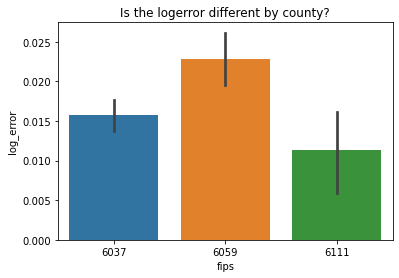

In [15]:
sns.barplot(data = train, x = 'fips', y = 'log_error')
plt.title("Is the logerror different by county?")
plt.show()

In [16]:
#T-test: logerror and counties
null_hypothesis = "there is no difference in logerror between counties."
alternative_hypothesis = "there is a difference in logerror between counties."
confidence_level = .95
alpha = 1 - confidence_level

la_county = train[train.fips  == 6037].log_error
other_counties = train[train.fips != 6037].log_error

t, p = stats.ttest_ind(la_county, other_counties)

print("t:", t, "p:", p)
if p < alpha:
    print("We reject the null hypothesis.")
    print("We can move forward with the alternative hypothesis:", alternative_hypothesis)

else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

t: -2.52714385008108 p: 0.011503667395718897
We reject the null hypothesis.
We can move forward with the alternative hypothesis: there is a difference in logerror between counties.


### Takeaways
- logerror is highest in Orange county
- logerror is roughly the same in Los Angeles and Ventura (slightly less in Ventura).
- T-test resulted in rejecting the null hypothesis meaning we can assume that there is a difference in logerror between counties
- Results show logerror is significantly different for properties in LA County vs Orange County vs Ventura County

#### Is there a correlation between square footage of a home and log error?

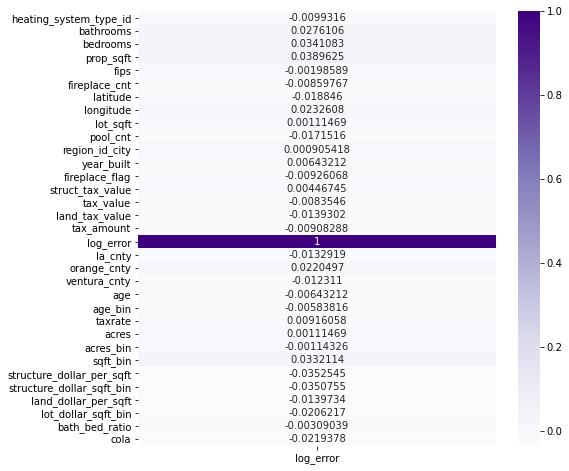

In [17]:
plt.figure(figsize = (8,8))

corrMatrix = train.corr()

htmp = pd.DataFrame(corrMatrix['log_error'],
              index=corrMatrix.index)

sns.heatmap(htmp, annot=True, fmt="g", cmap='Purples')

plt.show()

### Takeaways
- logerror doesn't have much correlation with anything
- however, logerror shows more correlation with prop_sqft than the rest of the features

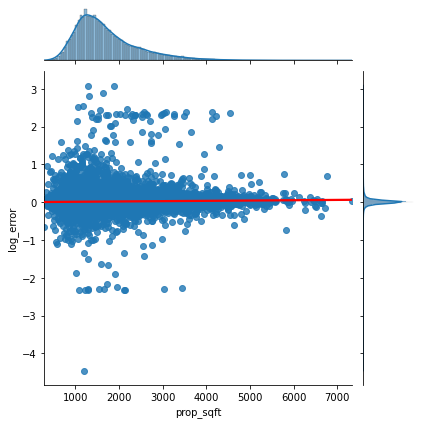

In [18]:
g = sns.jointplot(x="prop_sqft", y="log_error", data=train, kind='reg')
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)

### Takeaways
- slight upward trend in log error as square feet increases
- homes between 1,000-4,000 sq ft have quite a bit of variance in log error

In [19]:
#Correlation Test: logerror and square feet
null_hypothesis = "there is no correlation between logerror and square footage of a home."
alternative_hypothesis = "there is a correlation between logerror and square footage of a home."
confidence_level = .95
alpha = 1 - confidence_level

#Use pearsonr function
corr, p = stats.pearsonr(train.log_error, train.prop_sqft)

print("corr:", corr, "p:", p)

if p < alpha:
    print("We reject the null hypothesis.")
    print("We can move forward with the alternative hypothesis:", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

corr: 0.038962492989090436 p: 1.2635559282593872e-13
We reject the null hypothesis.
We can move forward with the alternative hypothesis: there is a correlation between logerror and square footage of a home.


### Takeaways
- Pearson's correlation test resulted in rejecting the null hypothesis, so we can assume that there is a correlation between logerror and square footage of a home
- Results show a correlation between square footage of a home and logerror

#### Could square footage and county location help predict log error?

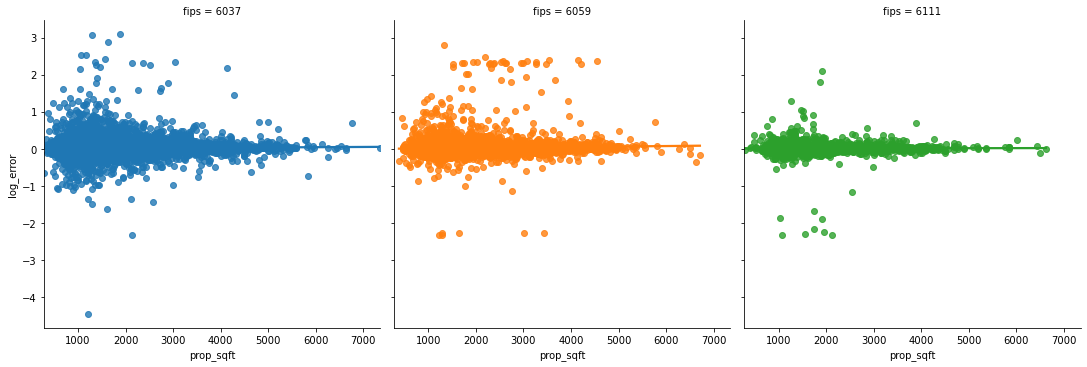

In [20]:
sns.lmplot(data=train, 
           x='prop_sqft', 
           y='log_error', 
           hue = 'fips', 
           col = 'fips', 
           col_wrap=3)

plt.show()

### Takeaways
- logerror shows the highest amount of variance for LA and Orange county.
- least amount of variance in Ventura county

#### Is there a relationship between tax value and log error?

<AxesSubplot:xlabel='tax_value', ylabel='log_error'>

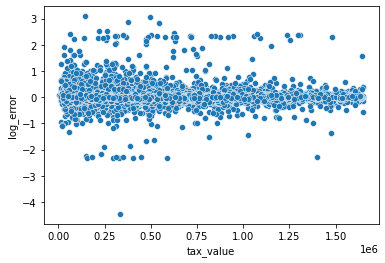

In [21]:
sns.scatterplot(x = 'tax_value', y = 'log_error', data = train)

In [23]:
#Correlation Test: tax value and logerror
null_hypothesis = "there is no correlation between tax value and logerror."
alternative_hypothesis = "there is a correlation between tax value and logerror."
confidence_level = .95
alpha = 1 - confidence_level

#Use pearsonr function
corr, p = stats.pearsonr(train.tax_value, train.log_error)

print("corr:", corr, "p:", p)
if p < alpha:
    print("We reject the null hypothesis.")
    print("We can move forward with the alternative hypothesis:", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

corr: -0.008354604671796393 p: 0.11221518311860741
We fail to reject the null hypothesis
Not enough evidence to support there is a correlation between tax value and logerror.


# Data Exploration with Clusters

In [24]:
# Useful functions for clustering:

#### These can be called using modeling.py (for final notebook)
def create_cluster(train, X, k):
    '''
    takes in train, X df with variables to cluster on, and k.
    
    It scales the X, calculates the clusters, 
    
    returns train (with clusters), 
    the Scaled dataframe,
    the scaler,
    kmeans object, 
    and unscaled centroids as a dataframe
    '''
    
    #scale X
    scaler = MinMaxScaler(copy=True).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    
    #calculate clusters
    kmeans = KMeans(n_clusters = k, random_state = 123)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    train['cluster'] = kmeans.predict(X_scaled)
    train['cluster'] = 'cluster_' + train.cluster.astype(str)
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    
    return train, X_scaled, scaler, kmeans, centroids


def create_scatter_plot(x,y,train,kmeans, X_scaled, scaler):
    '''
    takes in x and y variable names as strings, 
    along with returned objects from previous create_cluster function,
    and creates a plot
    '''
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = train, hue = 'cluster')
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')
    

### 1st Cluster Combination: Clustering for tax_value and prop sq ft

In [25]:
#start w/ 2 features
X = train[['tax_value', 'prop_sqft']]
X.head()

,tax_value,prop_sqft
parcelid,,
11053337,487320.0,1641.0
11184707,86146.0,1854.0
12111920,127795.0,807.0
12730510,353537.0,1045.0
11123078,569542.0,2040.0


In [26]:
#scale data
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
X_scaled.head()

,tax_value,prop_sqft
11053337,0.293876,0.192558
11184707,0.050324,0.222694
12111920,0.075609,0.074561
12730510,0.212656,0.108234
11123078,0.343793,0.249010


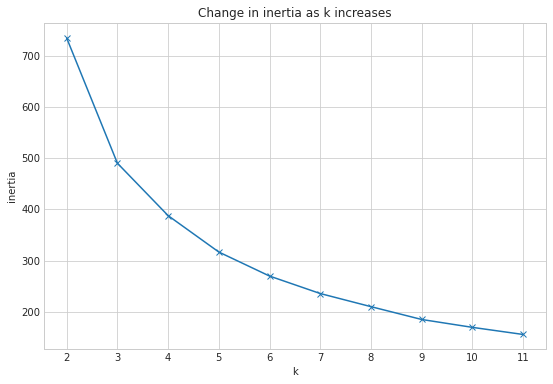

In [27]:
#plot inertia vs k to choose k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

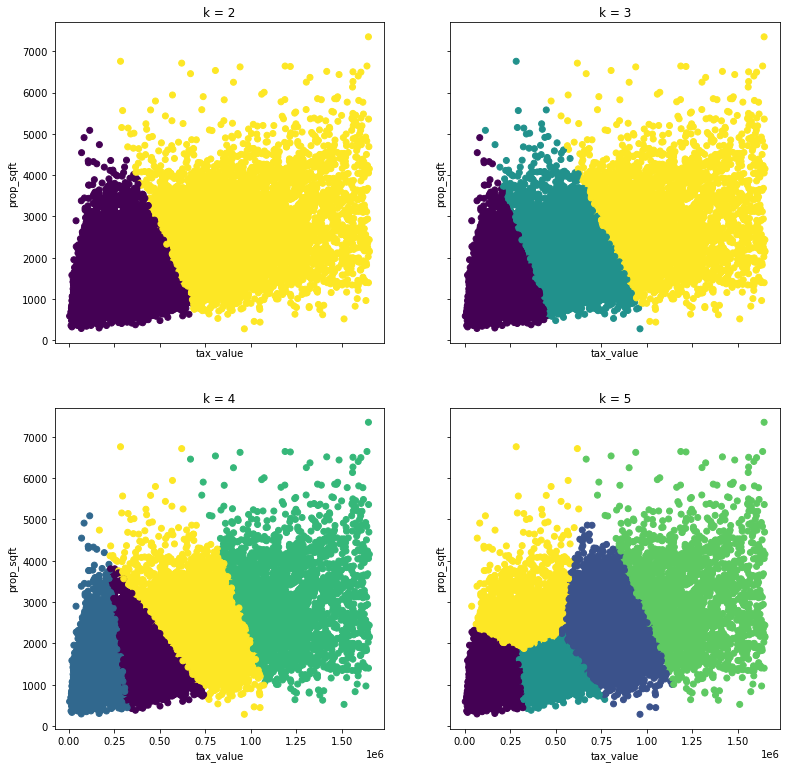

In [28]:
# visualize k for tax value and square feet
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
    ax.scatter(X.tax_value, X.prop_sqft, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='tax_value', ylabel='prop_sqft')

Best to choose k = 4 based on elbow method and visualization

In [29]:
# Make the kmeans object
kmeans = KMeans(n_clusters=4, random_state=123)

# fit the kmeans model
kmeans.fit(X_scaled)

# use the thing
X_scaled["cluster"] = kmeans.predict(X_scaled)
X_scaled.head()

,tax_value,prop_sqft,cluster
11053337,0.293876,0.192558,2
11184707,0.050324,0.222694,1
12111920,0.075609,0.074561,1
12730510,0.212656,0.108234,2
11123078,0.343793,0.249010,0


In [30]:
#summary statistics for each cluster
cluster0 = X_scaled[X_scaled.cluster == 0]
cluster1 = X_scaled[X_scaled.cluster == 1]
cluster2 = X_scaled[X_scaled.cluster == 2]
cluster3 = X_scaled[X_scaled.cluster == 3]

X_scaled.groupby("cluster").describe().T

cluster                    0             1             2            3
tax_value count  6689.000000  14001.000000  13128.000000  2326.000000
          mean      0.421725      0.095093      0.252919     0.727875
          std       0.081074      0.046672      0.053355     0.123374
          min       0.099338      0.000000      0.131276     0.403374
          25%       0.366500      0.051808      0.209734     0.627767
          50%       0.417387      0.095374      0.246752     0.708701
          75%       0.478782      0.135572      0.289926     0.817910
          max       0.648227      0.191993      0.442933     1.000000
prop_sqft count  6689.000000  14001.000000  13128.000000  2326.000000
          mean      0.289395      0.156910      0.178293     0.390851
          std       0.098293      0.069760      0.067268     0.144402
          min       0.000000      0.001132      0.013865     0.033956
          25%       0.217600      0.109225      0.131437     0.284168
          50%       0.280419      0.144595      0.167233     0.383843
          75%       0.350170      0.191285      0.214488     0.482421
          max       0.916242      0.679683      0.513582     1.000000

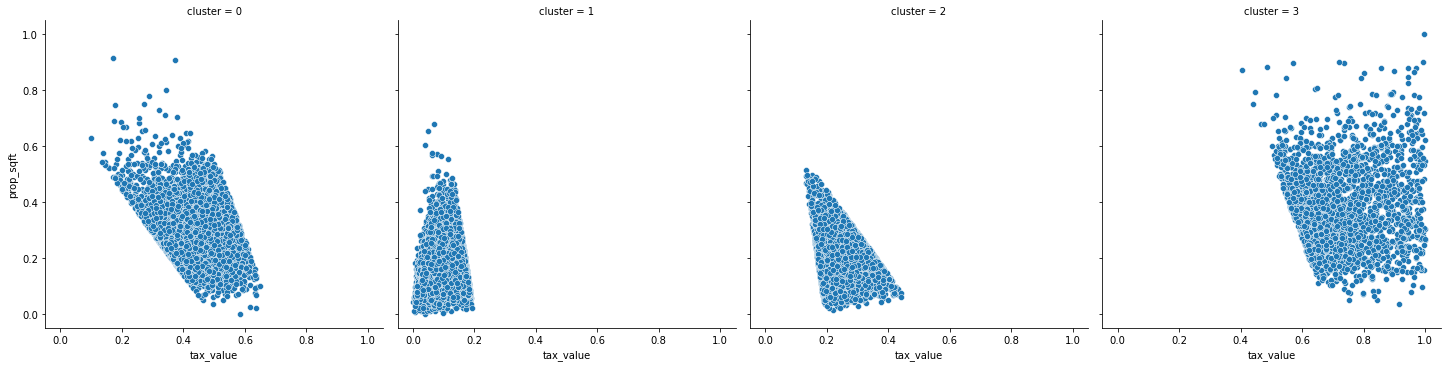

In [31]:
#visualize clusters
sns.relplot(x="tax_value", y="prop_sqft", col="cluster", data=X_scaled)

Text(0.5, 1.0, 'Do clusters reveal differences in tax value and error?')

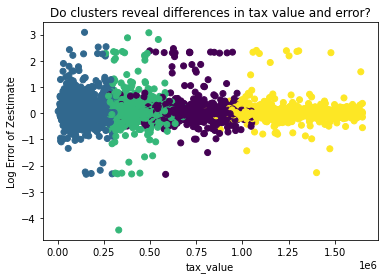

In [32]:
#visualize clusters against target variable log_error
plt.scatter(x = "tax_value", y = "log_error", data = train, c = X_scaled.cluster)

plt.xlabel('tax_value')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in tax value and error?")

Text(0.5, 1.0, 'Do clusters reveal differences in prop sqft and error?')

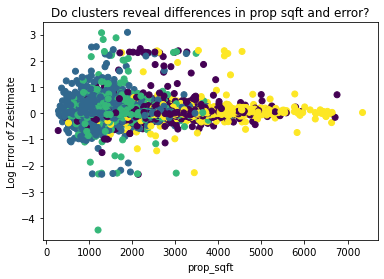

In [33]:
#visualize clusters against target variable log_error
plt.scatter(x = "prop_sqft", y = "log_error", data = train, c = X_scaled.cluster)

plt.xlabel('prop_sqft')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in prop sqft and error?")

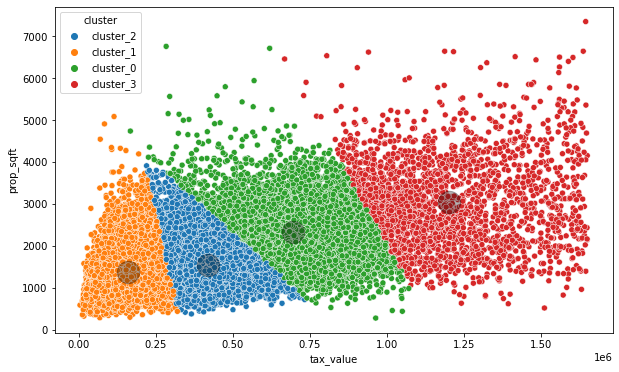

In [34]:
#visualize clusters with centroids
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 4)

create_scatter_plot('tax_value','prop_sqft',train,kmeans, X_scaled, scaler)


### 2nd Clustering Combination: Clustering for acres and age

In [39]:
#start w/ 2 features
X = train[['acres', 'age']]
X.head()

,acres,age
parcelid,,
11053337,0.197865,60.0
11184707,0.165565,25.0
12111920,0.496924,52.0
12730510,0.139922,63.0
11123078,0.239187,20.0


In [40]:
#scale data
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
X_scaled.head()

,acres,age
11053337,0.208263,0.423358
11184707,0.173308,0.167883
12111920,0.531899,0.364964
12730510,0.145558,0.445255
11123078,0.252981,0.131387


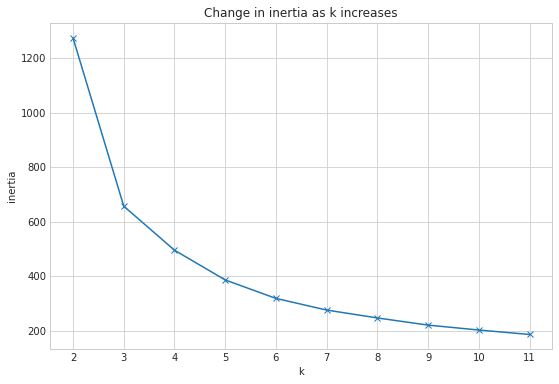

In [41]:
#plot inertia vs k to choose k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

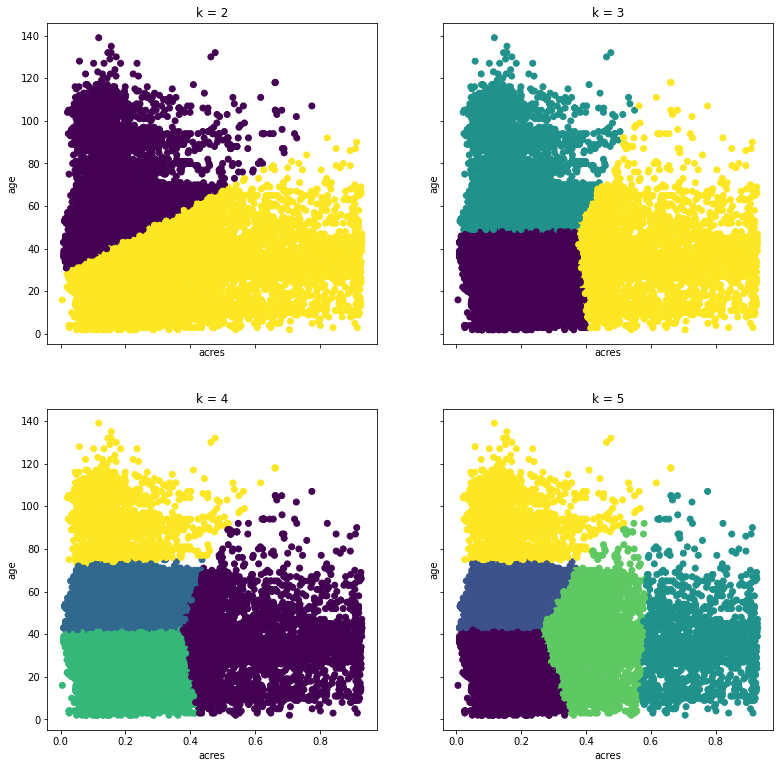

In [42]:
# visualize k for acres and age
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
    ax.scatter(X.acres, X.age, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='acres', ylabel='age')

Best to choose k = 4 based on elbow method and visualization

In [43]:
# Make the kmeans object
kmeans = KMeans(n_clusters=4)

# fit the kmeans model
kmeans.fit(X_scaled)

# use the thing
X_scaled["cluster"] = kmeans.predict(X_scaled)
X_scaled.head()

,acres,age,cluster
11053337,0.208263,0.423358,3
11184707,0.173308,0.167883,0
12111920,0.531899,0.364964,1
12730510,0.145558,0.445255,3
11123078,0.252981,0.131387,0


In [44]:
#summary statistics for each cluster
cluster0 = X_scaled[X_scaled.cluster == 0]
cluster1 = X_scaled[X_scaled.cluster == 1]
cluster2 = X_scaled[X_scaled.cluster == 2]
cluster3 = X_scaled[X_scaled.cluster == 3]

X_scaled.groupby("cluster").describe().T

cluster                 0            1            2             3
acres count  11159.000000  3632.000000  4668.000000  16685.000000
      mean       0.178415     0.648692     0.159580      0.174792
      std        0.084856     0.168595     0.073913      0.068762
      min        0.000000     0.400154     0.017266      0.004944
      25%        0.120839     0.499994     0.119112      0.139496
      50%        0.166253     0.610727     0.148216      0.162377
      75%        0.222536     0.779856     0.178749      0.196214
      max        0.443382     1.000000     0.710052      0.466163
age   count  11159.000000  3632.000000  4668.000000  16685.000000
      mean       0.169819     0.253457     0.633986      0.411780
      std        0.077673     0.123431     0.075917      0.059004
      min        0.000000     0.000000     0.518248      0.291971
      25%        0.102190     0.182482     0.562044      0.372263
      50%        0.182482     0.248175     0.642336      0.423358
      75%        0.233577     0.321168     0.671533      0.459854
      max        0.291971     0.766423     1.000000      0.532847

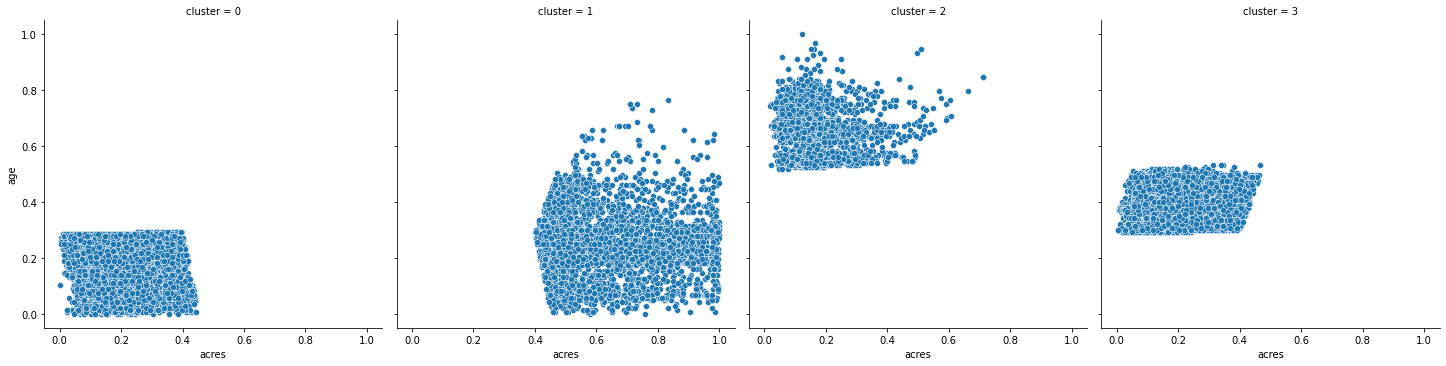

In [45]:
#visualize clusters
sns.relplot(x="acres", y="age", col="cluster", data=X_scaled)

Text(0.5, 1.0, 'Do clusters reveal differences in acres and error?')

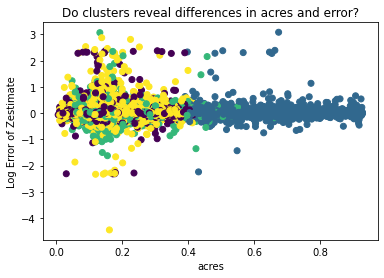

In [46]:
#visualize clusters against target variable log_error
plt.scatter(x = "acres", y = "log_error", data = train, c = X_scaled.cluster)

plt.xlabel('acres')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in acres and error?")

Text(0.5, 1.0, 'Do clusters reveal differences in age and error?')

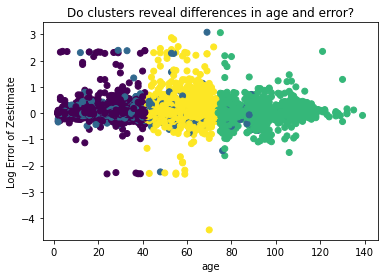

In [47]:
#visualize clusters against target variable log_error
plt.scatter(x = "age", y = "log_error", data = train, c = X_scaled.cluster)

plt.xlabel('age')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in age and error?")

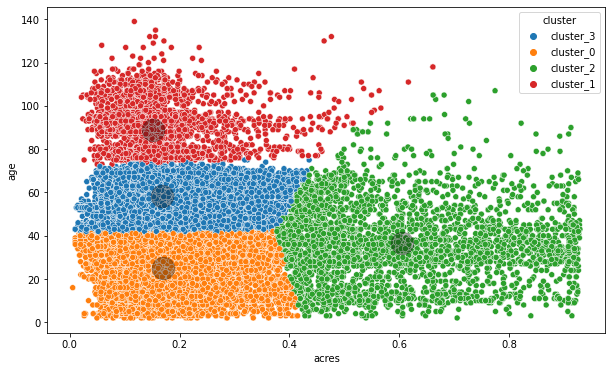

In [48]:
#visualize clusters with centroids
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 4)

create_scatter_plot('acres','age',train,kmeans, X_scaled, scaler)

### 3rd Clustering Combination: Clustering for latitude and longitude

In [49]:
#start w/ 2 features
X = train[['latitude', 'longitude']]
X.head()

,latitude,longitude
parcelid,,
11053337,0.342330,-1.184758
11184707,0.346181,-1.181858
12111920,0.341421,-1.181280
12730510,0.339189,-1.180198
11123078,0.344540,-1.184890


In [50]:
#scale data
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
X_scaled.head()

,latitude,longitude
11053337,0.647710,0.521157
11184707,0.927249,0.672394
12111920,0.581725,0.702508
12730510,0.419725,0.758923
11123078,0.808104,0.514261


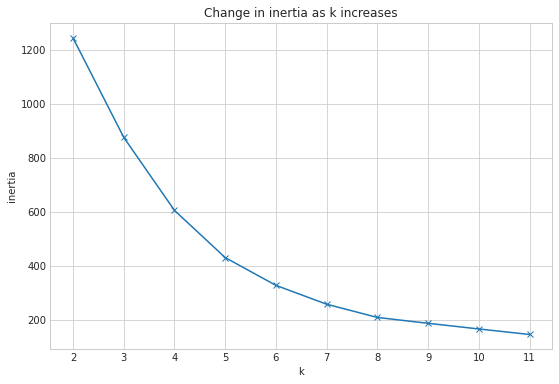

In [51]:
#plot inertia vs k to choose k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

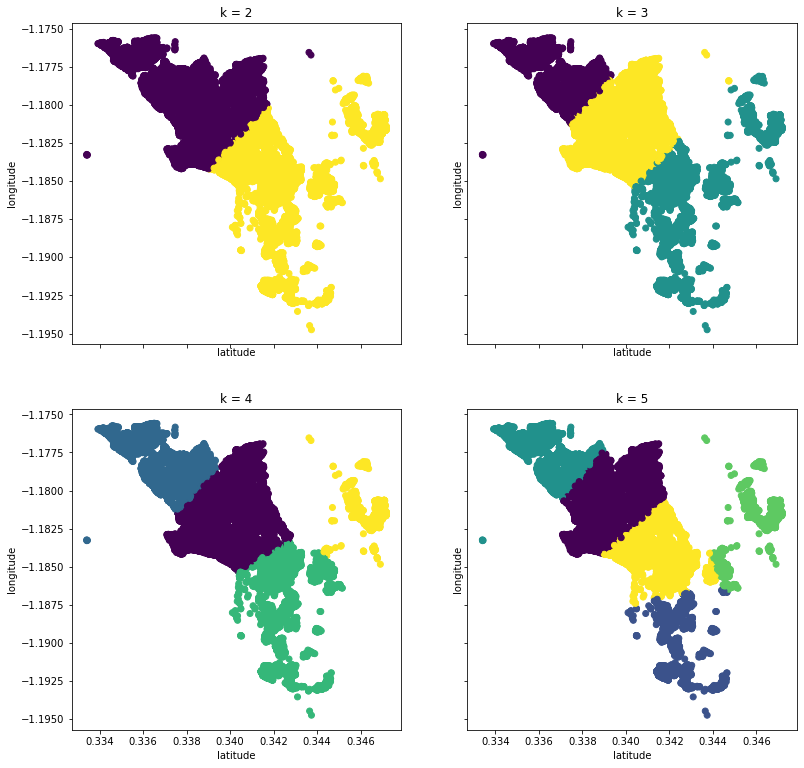

In [52]:
# visualize k for latitude and longitude
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
    ax.scatter(X.latitude, X.longitude, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='latitude', ylabel='longitude')

Best to choose k = 4 based on elbow method and visualization

In [53]:
# Make the kmeans object
kmeans = KMeans(n_clusters=4)

# fit the kmeans model
kmeans.fit(X_scaled)

# use the thing
X_scaled["cluster"] = kmeans.predict(X_scaled)
X_scaled.head()

,latitude,longitude,cluster
11053337,0.647710,0.521157,0
11184707,0.927249,0.672394,3
12111920,0.581725,0.702508,2
12730510,0.419725,0.758923,2
11123078,0.808104,0.514261,0


In [54]:
#summary statistics for each cluster
cluster0 = X_scaled[X_scaled.cluster == 0]
cluster1 = X_scaled[X_scaled.cluster == 1]
cluster2 = X_scaled[X_scaled.cluster == 2]
cluster3 = X_scaled[X_scaled.cluster == 3]

X_scaled.groupby("cluster").describe().T

cluster                    0            1             2            3
latitude  count  7647.000000  9726.000000  16760.000000  2011.000000
          mean      0.655899     0.255700      0.476250     0.933398
          std       0.063351     0.085349      0.091031     0.047181
          min       0.486012     0.000000      0.267345     0.741586
          25%       0.611893     0.197810      0.402228     0.893014
          50%       0.642613     0.254346      0.483998     0.945271
          75%       0.678999     0.322252      0.551174     0.974873
          max       0.852733     0.428788      0.680120     1.000000
longitude count  7647.000000  9726.000000  16760.000000  2011.000000
          mean      0.389884     0.868239      0.678719     0.700124
          std       0.141637     0.069494      0.096282     0.052254
          min       0.000000     0.597700      0.497022     0.516900
          25%       0.293196     0.810840      0.599003     0.671778
          50%       0.445787     0.869764      0.671121     0.698535
          75%       0.505289     0.927282      0.744234     0.728928
          max       0.598535     1.000000      0.929676     0.949719

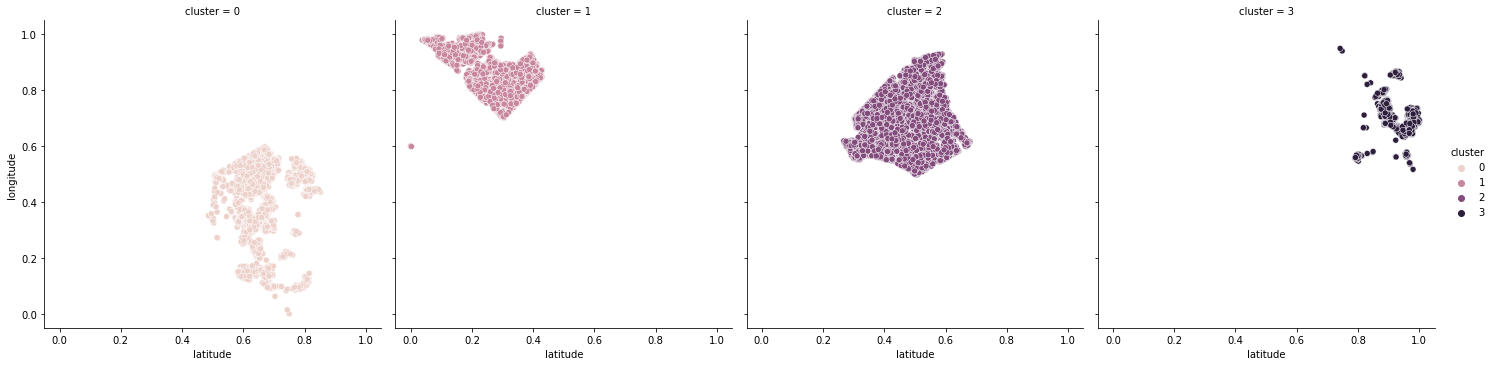

In [55]:
#visualize clusters
sns.relplot(x="latitude", y="longitude", col="cluster", hue="cluster", data=X_scaled)

Text(0.5, 1.0, 'Do clusters reveal differences in latitude and error?')

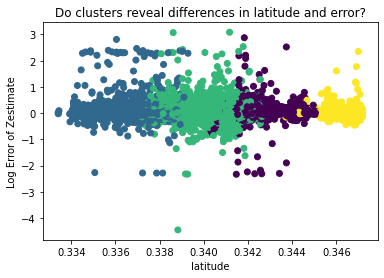

In [56]:
#visualize clusters against target variable log_error
plt.scatter(x = "latitude", y = "log_error", data = train, c = X_scaled.cluster)

plt.xlabel('latitude')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in latitude and error?")

Text(0.5, 1.0, 'Do clusters reveal differences in longitude and error?')

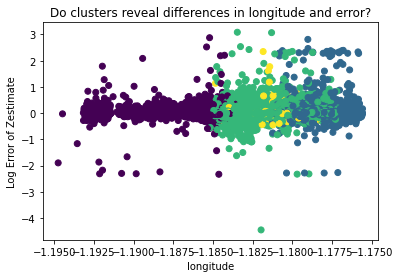

In [57]:
#visualize clusters against target variable log_error
plt.scatter(x = "longitude", y = "log_error", data = train, c = X_scaled.cluster)

plt.xlabel('longitude')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in longitude and error?")

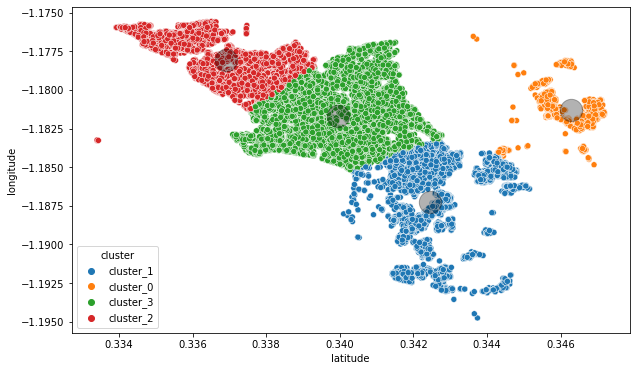

In [58]:
#visualize clusters with centroids
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 4)

create_scatter_plot('latitude','longitude',train,kmeans, X_scaled, scaler)

### Cluster Findings
- Clustering helped in understanding the data even better to select the features for our models.




- **tax_value and prop_sqft**
    - Created 4 clusters
        - low tax low sqft - low end suburbs - lower middle class
        - mid tax low sqft - mid-high end suburbs / low-mid end city - mid-high upper middle class
        - high tax low sqft - high end suburbs and city property - upper middle class+
        - high sqft - large houses all tax groups




- **acres and age**
    - Created 4 clusters
        - young property low-mid acrage - new residential suburban areas
        - mid century property low-mid acrage - mid century suburban and urban
        - old property low-mid acrage - old suburban and urban
        - high acrage - all ages suburban-rural areas




- **latitude and longitude**
    - Created 4 clusters:
        - Clusters follow the general county lines with the exception of cluster in the East.
        - County and location is a strong clustering feature

# Data Modeling and Evaluation

In [59]:
#restart w/ wrangle.py split func and scale func

#setting up vars
binary_vars = ['pool_cnt', 'fireplace_flag','la_cnty', 'orange_cnty', 'ventura_cnty', 'cola']
categorical_vars = ['heating_system_type_id', 'fips', 'fireplace_cnt', \
                    'heating_system_desc', 'region_id_city', 'acres_bin', 'sqft_bin',\
                    'structure_dollar_sqft_bin']
quant_vars = [ 'bathrooms', 'bedrooms', 'prop_sqft', 'lot_sqft', 'year_built',\
              'struct_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', \
              'structure_dollar_per_sqft', 'bath_bed_ratio']
categorical_target = 'log_error_class'
continuous_target = 'log_error'

#split data
train, validate, test = w.train_validate_test_split(df, 'log_error', seed=42)

#scale data
train, validate, test = w.train_validate_test_scale(train, validate, test, quant_vars)

In [60]:
#set up X inputs and y target variable for each split 
X_train = train.drop(columns=['log_error'])
y_train = train.log_error

X_validate = validate.drop(columns=['log_error'])
y_validate = validate.log_error

X_test = test.drop(columns=['log_error'])
y_test = test.log_error

### Models w/out clusters

#### Establish/Evaluate a Baseline Model

In [62]:
#Convert y_train and y_validate to dataframes to append the new columns with predicted values 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#Predict log_error_pred_mean
log_error_pred_mean = y_train['log_error'].mean()
y_train['log_error_pred_mean'] = log_error_pred_mean
y_validate['log_error_pred_mean'] = log_error_pred_mean

#Compute log_error_pred_median
log_error_pred_median = y_train['log_error'].median()
y_train['log_error_pred_median'] = log_error_pred_median
y_validate['log_error_pred_median'] = log_error_pred_median

#Evaluate the baseline model using the mean
#RMSE of log_error_pred_mean
rmse_train = mean_squared_error(y_train.log_error, y_train.log_error_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

#Evaluate the baseline model using the median
#RMSE of log_error_pred_mean
rmse_train = mean_squared_error(y_train.log_error, y_train.log_error_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_median) ** .5

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

RMSE using Mean
Train/In-Sample:  0.1598 
Validate/Out-of-Sample:  0.169
RMSE using Median
Train/In-Sample:  0.1601 
Validate/Out-of-Sample:  0.1694


### Findings:
- Using the mean for the baseline will be the benchmark for comparison since it performed better than using the median.

In [63]:
#incrementally building a df for comparison of metrics for model selection
metric_df = pd.DataFrame(data = [{'model': 'mean_baseline', 
                                  'RMSE_validate': rmse_validate,
                                  'r^2_validate': explained_variance_score(y_validate.log_error, y_validate.log_error_pred_mean)}])

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.169397,0.0


## LinearRegression (OLS) Model

In [64]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data
lm.fit(X_train, y_train.log_error)


# predict train
y_train['log_error_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.log_error, y_train.log_error_pred_lm) ** (1/2)


# predict validate
y_validate['log_error_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

ValueError: could not convert string to float: 'Central'

In [ ]:
metric_df = metric_df.append({'model': 'OLS Regressor', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.log_error, y_validate.log_error_pred_lm)}, ignore_index=True)

metric_df

## LassoLars Model

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train.log_error)


# predict train
y_train['log_error_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.log_error, y_train.log_error_pred_lm) ** (1/2)


# predict validate
y_validate['log_error_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
metric_df = metric_df.append({'model': 'Lasso alpha 1', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.log_error, y_validate.log_error_pred_lars)}, ignore_index=True)

metric_df

## TweedieRegressor (GLM Poisson) Model

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. 
glm.fit(X_train, y_train.log_error)


# predict train
y_train['log_error_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.log_error, y_train.log_error_pred_glm) ** (1/2)


# predict validate
y_validate['log_error_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.log_error, y_train.log_error_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
metric_df = metric_df.append({'model': 'GLM (Poisson)', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.log_error, y_validate.log_error_pred_glm)}, ignore_index=True)

metric_df

## Polynomial Regression (Quadratic) Model

In [ ]:
## Polynomial Features ##
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate & X_test
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_tes)


## LinearRegression ##
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data
lm2.fit(X_train, y_train.log_error)


# predict train
y_train['log_error_pred_lm2'] = lm2.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.log_error, y_train.log_error_pred_lm2) ** (1/2)


# predict validate
y_validate['log_error_pred_lm2'] = lm2.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
metric_df = metric_df.append({'model': 'Quadratic Model', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.log_error, y_validate.log_error_pred_lm2)}, ignore_index=True)

metric_df

### Models w/ clusters